In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import MultiPolygon, Polygon, Point, shape
import json
from datetime import date
import re

# Load the Data Set for Manhattan

In [2]:
# Connect to the database
database = "/Users/zachcuddihy/Projects/apartment_scraper/data/apartments.db"
conn = create_connection(database)
c = conn.cursor()

In [3]:
query = f"""SELECT * FROM units
            JOIN properties
            USING (property_name)
            WHERE city_name='San Francisco';
"""

units = pd.read_sql_query(query, conn)
conn.close()

# Correct the dishwasher column to 1s and zeros only
units.dishwasher = np.where(units.dishwasher == 'True',
                            1,
                            units.dishwasher)
units.dishwasher = np.where(units.dishwasher == 'False',
                            0,
                            units.dishwasher)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url
0,Grosvenor Atrium,94109,Studio 1 bath,2395.0,0,1,471.5,2022-04-02,2022-04-02,1,...,37.79581,-122.42489,Pacific Heights,94109,Grosvenor Atrium is a professionally-managed a...,"Fitness Center, Laundry Facility On-Site, Saun...",San Francisco,1975,1,https://www.apartments.com/grosvenor-atrium-sa...
1,Grosvenor Atrium,94109,Studio 1 bath,2395.0,0,1,471.5,2022-04-02,2022-04-02,1,...,37.79581,-122.42489,Pacific Heights,94109,Grosvenor Atrium is a professionally-managed a...,"Fitness Center, Laundry Facility On-Site, Saun...",San Francisco,1975,1,https://www.apartments.com/grosvenor-atrium-sa...
2,Grosvenor Atrium,94109,Studio 1 bath,2395.0,0,1,471.5,2022-04-10,2022-04-10,1,...,37.79581,-122.42489,Pacific Heights,94109,Grosvenor Atrium is a professionally-managed a...,"Fitness Center, Laundry Facility On-Site, Saun...",San Francisco,1975,1,https://www.apartments.com/grosvenor-atrium-sa...
3,Grosvenor Atrium,94109,Studio 1 bath,2395.0,0,1,471.5,2022-04-19,2022-04-19,1,...,37.79581,-122.42489,Pacific Heights,94109,Grosvenor Atrium is a professionally-managed a...,"Fitness Center, Laundry Facility On-Site, Saun...",San Francisco,1975,1,https://www.apartments.com/grosvenor-atrium-sa...
4,Grosvenor Atrium,94109,Two Bedroom 2 Bath VIEW,4475,2,2,997.5,2022-04-02,2022-04-02,1,...,37.79581,-122.42489,Pacific Heights,94109,Grosvenor Atrium is a professionally-managed a...,"Fitness Center, Laundry Facility On-Site, Saun...",San Francisco,1975,1,https://www.apartments.com/grosvenor-atrium-sa...


In [4]:
# Drop duplicate unit listings 
units.drop_duplicates(['property_name', 'unit_id', 'property_zipcode'], keep='last', inplace=True)

In [5]:
units.dtypes

property_name           object
property_zipcode        object
unit_id                 object
rent                    object
beds                    object
baths                   object
sqft                    object
date_available          object
date_scraped            object
fitness_center           int64
air_conditioning         int64
in_unit_washer_dryer     int64
laundry_facilities       int64
car_charging             int64
roof                     int64
concierge                int64
pool                     int64
elevator                 int64
garage                   int64
dogs_allowed             int64
cats_allowed             int64
income_restrictions      int64
latitude                object
longitude               object
neighborhood            object
zipcode                 object
description             object
unique_features         object
city_name               object
year_built              object
dishwasher              object
property_url            object
dtype: o

In [6]:
pd.concat([units.isnull().sum(),units.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
property_name,0,0
property_zipcode,0,0
unit_id,0,0
rent,0,10
beds,0,0
baths,0,0
sqft,0,278
date_available,0,0
date_scraped,0,0
fitness_center,0,0


In [7]:
# Remove all units without square feet or rent values
# It's possible to impute these missing values
# but likely will skew any results that are generated
units = units[units.sqft != '']
units = units[units.rent != '']

In [8]:
units.rent=units.rent.astype(float)
units.sqft=units.sqft.astype(float)
units.beds=units.beds.astype(int)
units.baths=units.baths.astype(float)
units.latitude=units.latitude.astype(float)
units.longitude=units.longitude.astype(float)
units.date_available=units.date_available.astype('datetime64[ns]')
units.date_scraped=units.date_scraped.astype('datetime64[ns]')

# Plot the data points to visualize the apartment locations

In [10]:
fig = px.scatter_mapbox(units,
              lat="latitude" ,
              lon="longitude",
              hover_name="property_name",
              mapbox_style='carto-positron',    
              zoom=11)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Explore any possible outliers

In [11]:
# Descriptive stats based on setting a specific target column
def descriptive_stats(target,df):
    average = df.groupby('beds', as_index=True)[target].mean()
    ci_5 = df.groupby('beds', as_index=True)[target].quantile(0.05)    #5th Percentile
    ci_95 = df.groupby('beds', as_index=True)[target].quantile(0.95)   #95th Percentile
    minimum= df.groupby('beds', as_index=True)[target].min()
    maximum = df.groupby('beds', as_index=True)[target].max()
    std = df.groupby('beds', as_index=True)[target].std()
    num = df.groupby('beds', as_index=True)[target].count()
    
    stats_df = pd.DataFrame({f'Average {target}':average, 
                            '5th Percentile':ci_5,
                            '95th Percentile':ci_95,
                            'Minimum':minimum, 
                            'Maximum':maximum,
                            'Standard Deviation':std,
                            'Number of Units': num})
    
    stats_df.reset_index(inplace=True)
    return stats_df

In [12]:
# Add a price/sqft column that will be useful for visualization and detecting outliers
units['price/sqft'] = units.rent / units.sqft

In [13]:
# Get the descriptive stats for the price/sqft column
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,6.459209,4.051784,11.000000,2.687500,23.186667,2.632567,516
1,1,5.198267,3.237204,7.515331,0.998077,29.500000,1.583187,1104
2,2,4.619103,3.001203,6.406845,1.477273,11.306533,1.096192,894
3,3,3.783456,2.469043,5.301418,0.535714,7.000000,0.978025,207
4,4,3.942744,2.492980,6.429996,1.914583,9.342419,1.391614,86
5,5,3.321163,1.829530,4.441058,1.713533,4.615385,0.929331,18
6,6,4.220394,2.747537,5.682394,2.571429,5.933333,1.239473,6
7,7,3.850000,3.850000,3.850000,3.850000,3.850000,NaN,1


* We can see that there are very few instances of 4, 5 and 6 bedroom options. Those will need to be dropped as there isn't sufficent data. 
* There seems to be sever very large values in each bed column that are skewing the data set. The 95th percentile is roughly $8-10/sqft where as the standard deviations are much larger than that. We'll start by capping the price/sqft at $20 then further examining the data. 

In [14]:
# Drop the 4, 5 and 6 bedroom units since they make up a small portion of the dataset
units = units[units.beds < 4]
units = units[units['price/sqft'] < 20]
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,6.340461,4.048231,10.950000,2.687500,19.301205,2.270627,512
1,1,5.176235,3.236866,7.509125,0.998077,12.109375,1.404407,1103
2,2,4.619103,3.001203,6.406845,1.477273,11.306533,1.096192,894
3,3,3.783456,2.469043,5.301418,0.535714,7.000000,0.978025,207


Lets further visualize the distribution of the rent and sqft for each bedroom to verify no further outliers remain. 

In [15]:
def outlier_plot(beds:int, target: str):
    # Main plot
    f, ax = plt.subplots(figsize = (12,12))
    ax = sns.histplot(x=units[units.beds == beds][target], kde=True)
    
    # Add outlier bands
    lower_std = units[units.beds == beds][target].mean() - 2*units[units.beds == beds][target].std()
    upper_std = units[units.beds == beds][target].mean() + 2*units[units.beds == beds][target].std()
    lower_quan = units[units.beds == beds][target].quantile(0.025)
    upper_quan = units[units.beds == beds][target].quantile(0.975)
    
    #Plot upper and lower based bands
    ax.axvline(lower_std, color='red', ls='-', alpha=0.4, lw=10)
    ax.axvline(upper_std, color='red', ls='-', alpha=0.4, lw=10)
    ax.axvline(lower_quan, color='green', ls='-', alpha=0.4, lw=10)
    ax.axvline(upper_quan, color='green', ls='-', alpha=0.4, lw=10)
    ax.set_title(f'Outlier Visualization: {beds} bedrooms versus {target}', fontsize=15)

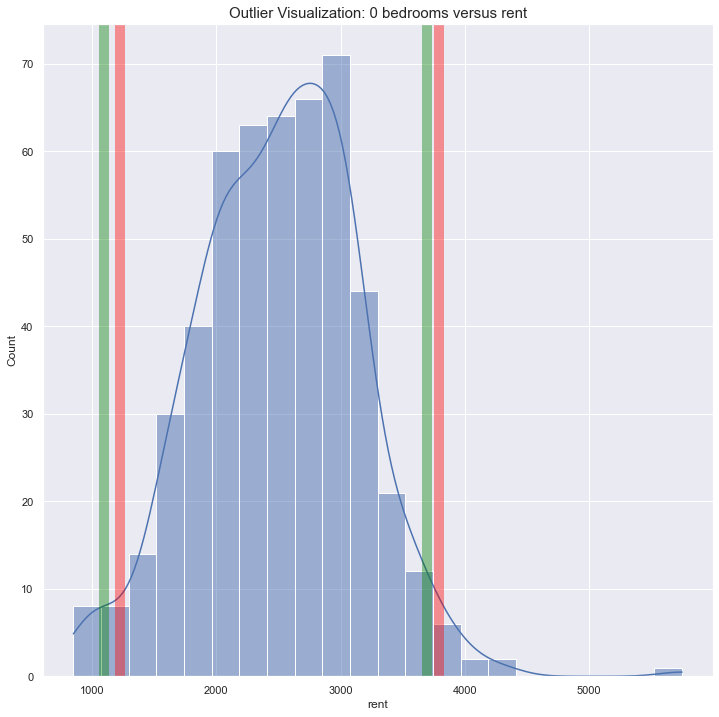

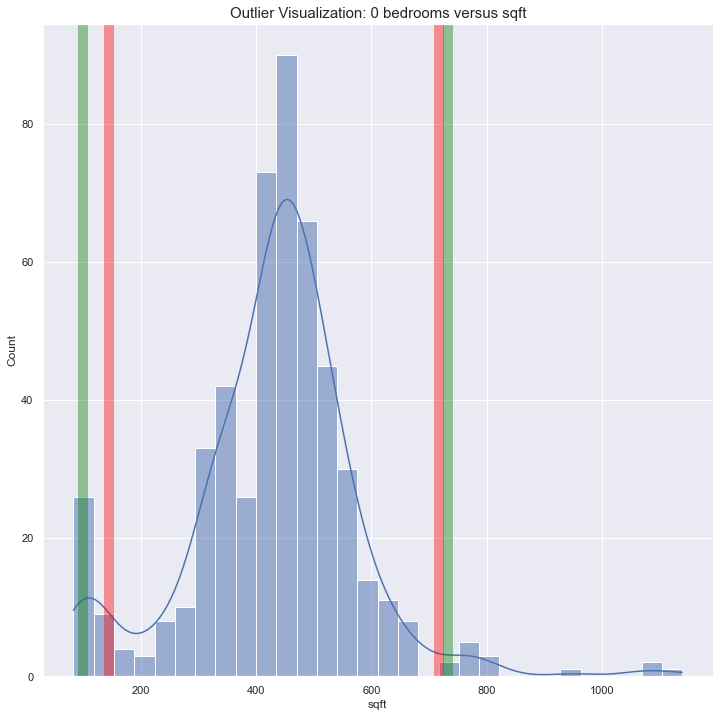

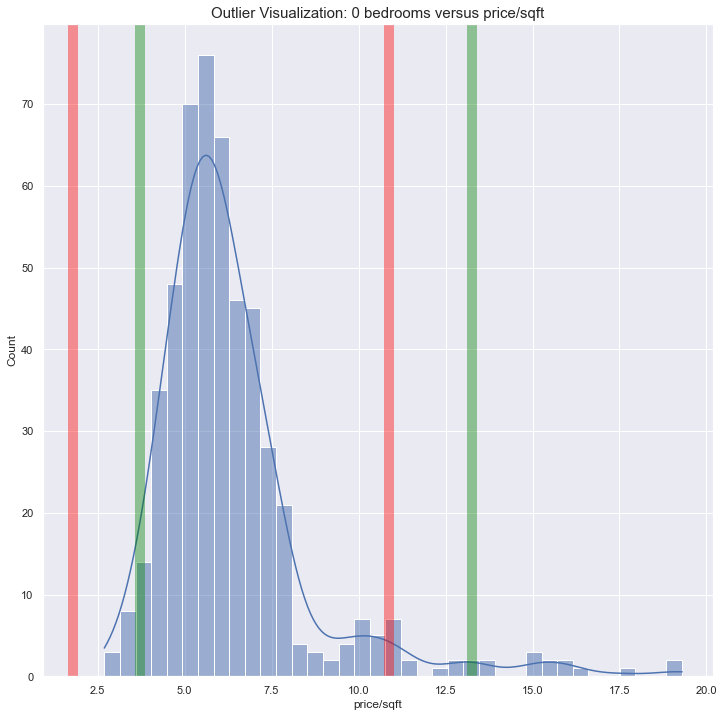

In [16]:
# Outlier plots for studios
outlier_plot(0,'rent')
outlier_plot(0,'sqft')
outlier_plot(0,'price/sqft')

In [17]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>1000) & (units.beds==0)].index, inplace=True)
units.drop(units[(units.rent>5000) & (units.beds==0)].index, inplace=True)

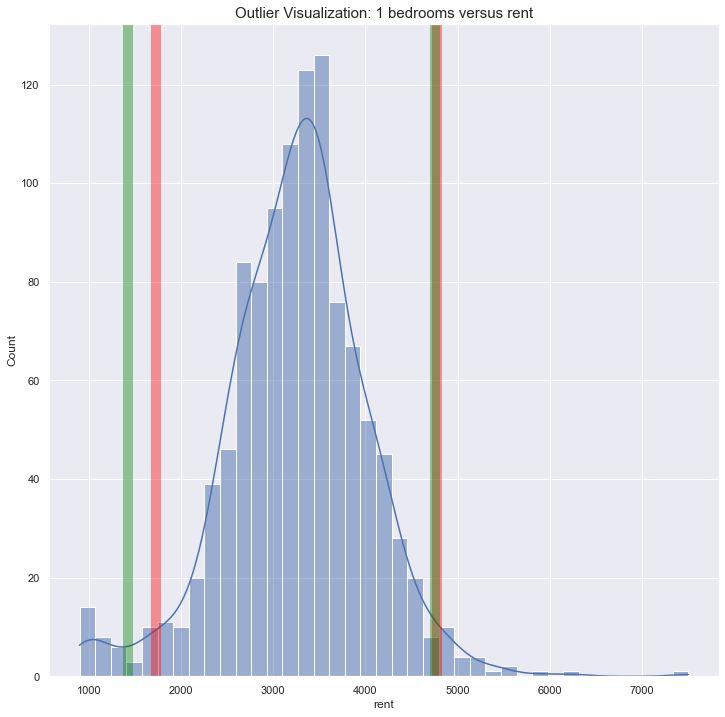

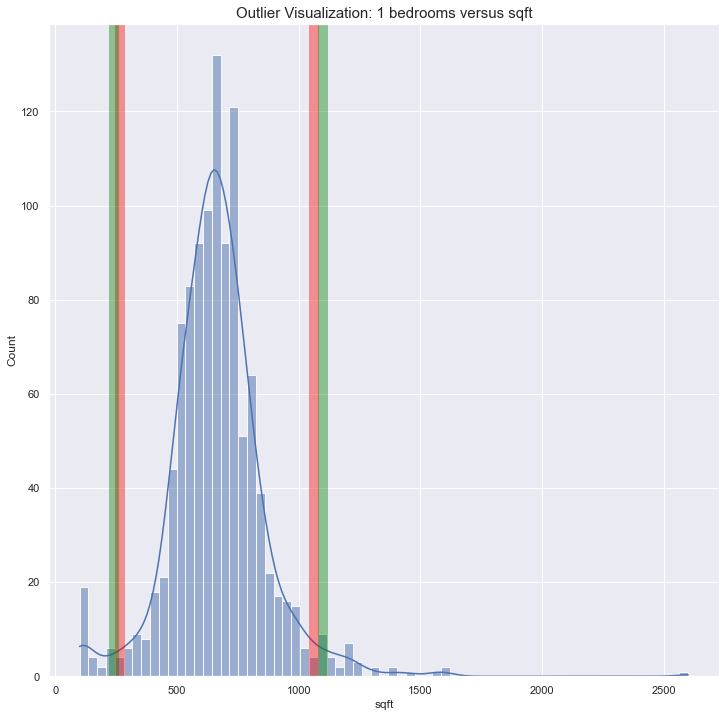

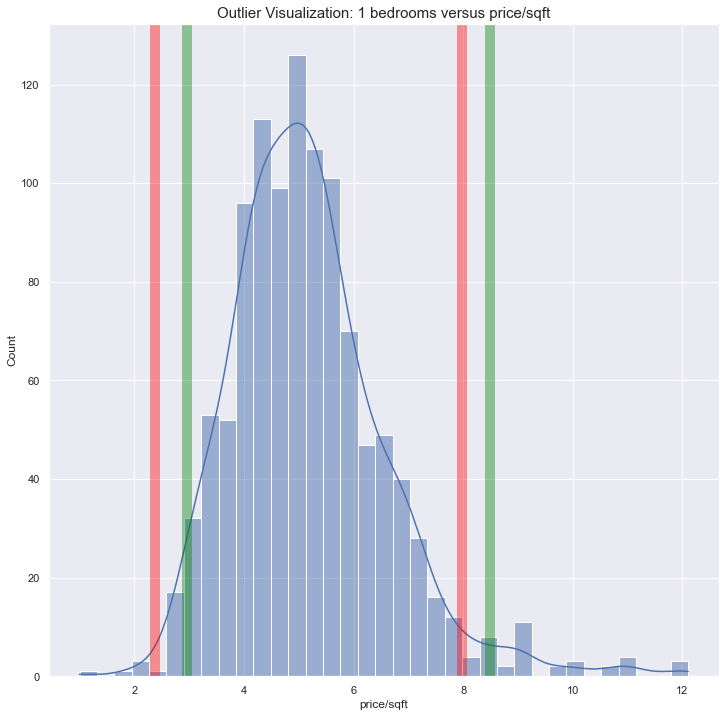

In [18]:
# Outlier plots for studios
beds = 1
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

According to the price/sqft plot, the data looks fairly reasonably so we'll explore the few data points that appears to be an outliers.

In [19]:
units[(units.beds == 1) & (units.sqft >1500)]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,city_name,year_built,dishwasher,property_url,price/sqft
261,639 Minna St Unit 1,94103,1,4400.0,1,2.0,1600.0,2022-04-19,2022-04-19,0,...,-122.41125,SoMa,94103,"HUGE 1500+ sq ft loft in SOMA! 2 levels, parki...",,San Francisco,NULL,0,https://www.apartments.com/639-minna-st-san-fr...,2.750000
3884,"1 br, 1 bath House - 650 2nd Street #301",94107,650 2nd St,4995.0,1,1.0,1565.0,2022-04-10,2022-04-10,0,...,-122.39156,Mission Bay,94107,(916) 835-0699 - Amazing Furnished Loft in SOM...,Garage,San Francisco,NULL,0,https://www.apartments.com/1-br-1-bath-house-6...,3.191693
5495,Bennett Lofts,94107,10-303,3519.0,1,1.0,1587.0,2022-05-07,2022-04-10,0,...,-122.39746,Mission Bay,94107,Bennett Lofts apartments await you in two dist...,"ADA\xa0features, Courtesy Patrol, Online resid...",San Francisco,2004,1,https://www.apartments.com/bennett-lofts-san-f...,2.217391
5936,155 Parnassus Ave,94117,155 Parnassus Ave,2595.0,1,1.0,2600.0,2022-04-10,2022-04-10,1,...,-122.45140,Cole Valley,94117,Charming top back unit in well maintained 4 un...,,San Francisco,NULL,1,https://www.apartments.com/155-parnassus-ave-s...,0.998077


From the looks of it, these all appear to be realistic apartments as they represent some of the luxury properties that people can rent. However, they make up a fraction of the data set and won't necessarily be useful data points for our model. 

In [20]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>1500) & (units.beds==1)].index, inplace=True)
units.drop(units[(units.rent>7000) & (units.beds==1)].index, inplace=True)

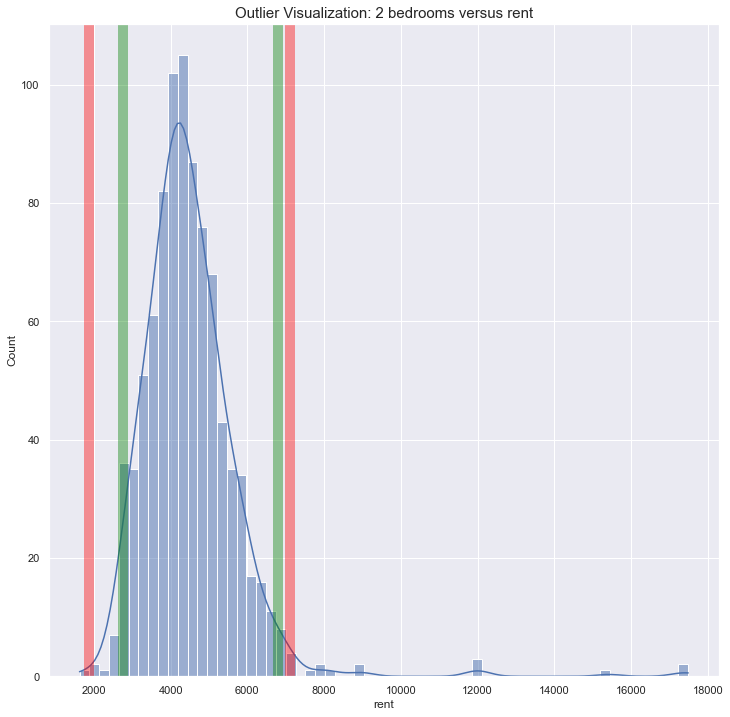

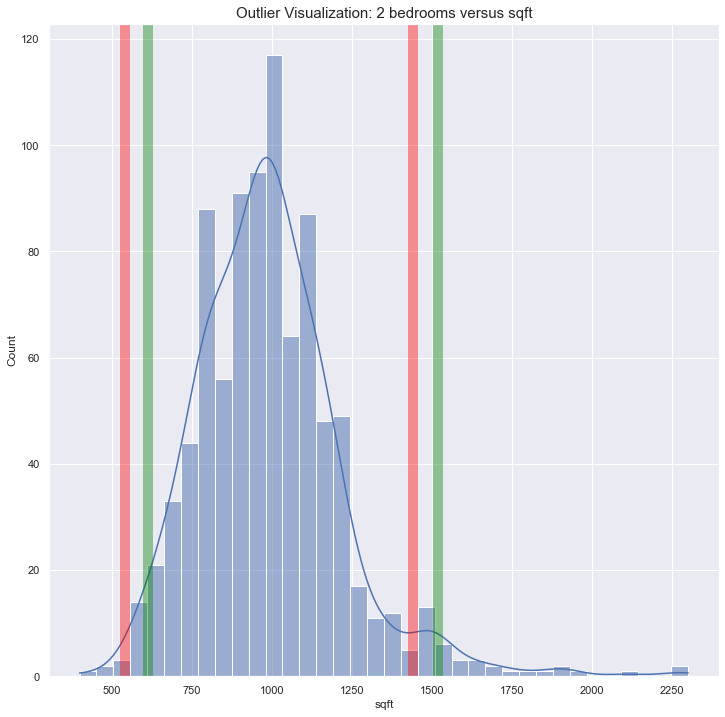

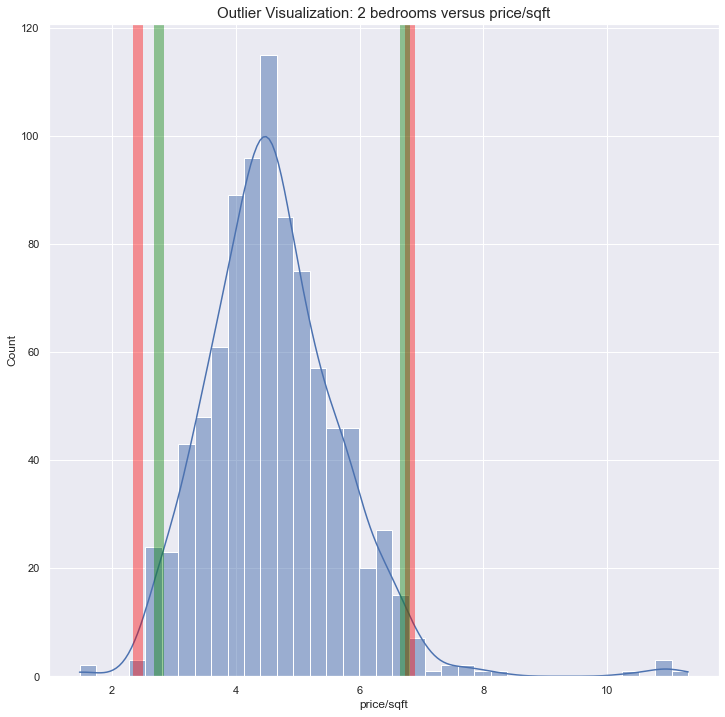

In [21]:
# Outlier plots for studios
beds = 2
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

In [22]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>2000) & (units.beds==2)].index, inplace=True)
units.drop(units[(units.rent>12000) & (units.beds==2)].index, inplace=True)
units.drop(units[(units['price/sqft']>10) & (units.beds==2)].index, inplace=True)

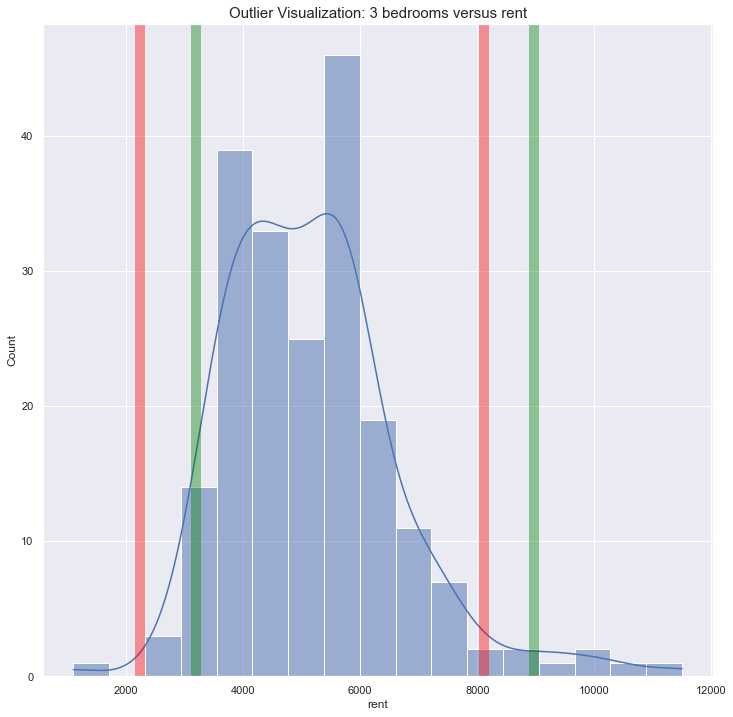

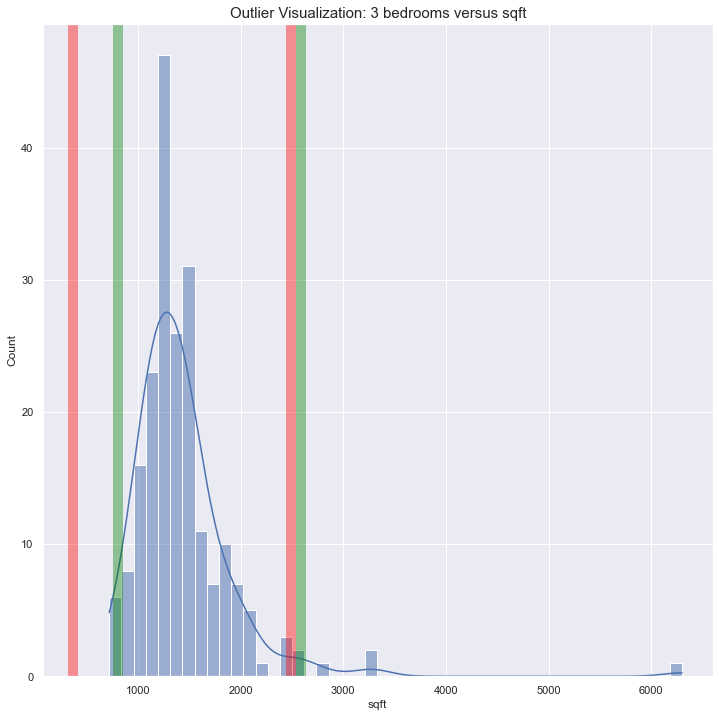

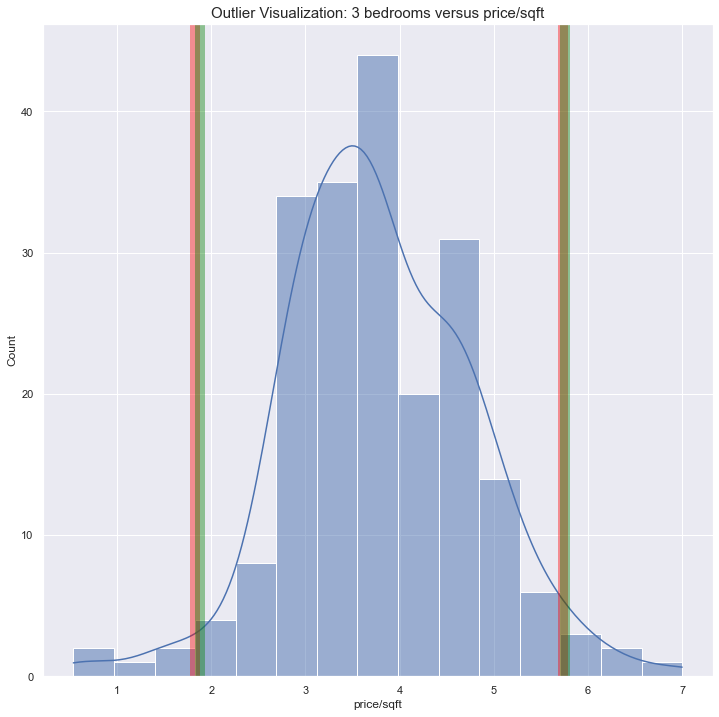

In [23]:
# Outlier plots for studios
beds = 3
outlier_plot(beds,'rent')
outlier_plot(beds,'sqft')
outlier_plot(beds,'price/sqft')

In [24]:
# Further remove these outliers as they will only skew our data
units.drop(units[(units.sqft>6000) & (units.beds==3)].index, inplace=True)

# Initial Exploration

### Skewness of rent and sqft columns

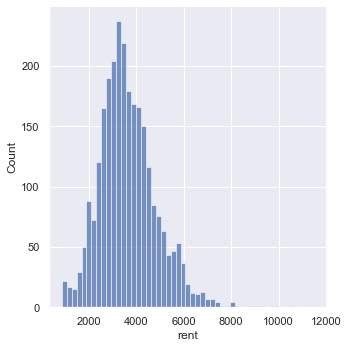

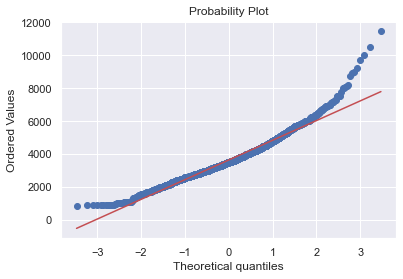

In [25]:
#Distribution of the rent column
sns.displot(units.rent)
fig = plt.figure()
res = stats.probplot(units.rent, plot=plt)

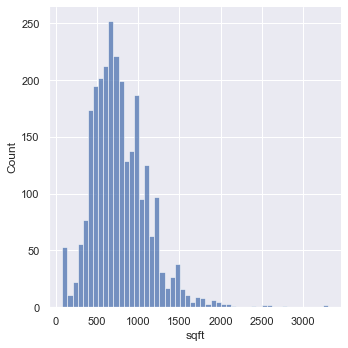

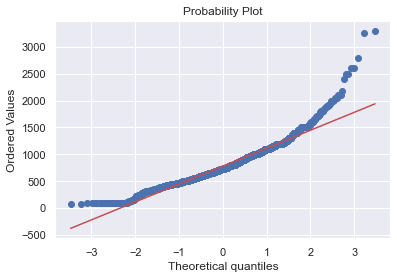

In [26]:
#Distribution of the sqft column
sns.displot(units.sqft)
fig = plt.figure()
res = stats.probplot(units.sqft, plot=plt)

### SQFT versus Rent

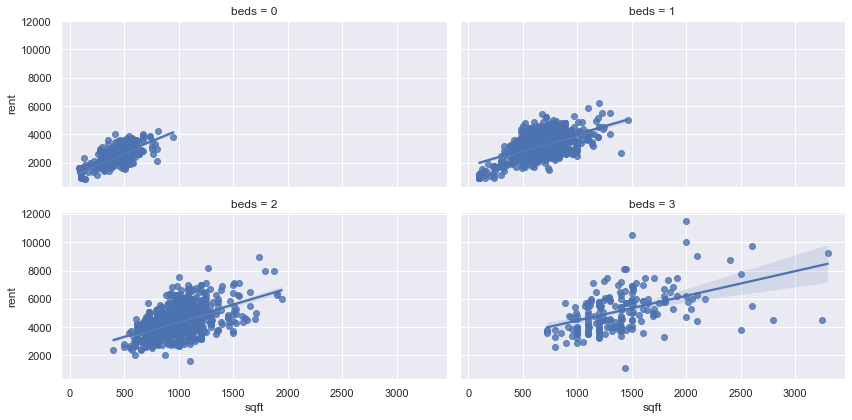

In [27]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'sqft','rent')

### Add location to waterfront, transit stops and midtown/wall street

In [77]:
# Load MTA Stop locations and clean to useable form
# Data comes in the form of: POINT(LAT LONG)
mta_stops = pd.read_csv('./data/external/mta_locations.csv')['the_geom']
mta_stops.replace('[POINT()]', '',regex=True, inplace=True)
mta_stops = mta_stops.str.strip()
mta_stops = pd.DataFrame(mta_stops.str.split(' ').to_list())
mta_stops.rename(columns={0:'lon', 1: 'lat'}, inplace=True)
mta_stops.lat=mta_stops.lat.astype(float)
mta_stops.lon=mta_stops.lon.astype(float)
mta_stops.drop_duplicates(inplace=True)
mta_stops.head()

,lon,lat
0,-73.868356,40.849169
1,-73.868213,40.849128
2,-73.873499,40.841223
3,-73.872892,40.841453
4,-73.879623,40.840815


In [78]:
# Calculate the nearest MTA stop for each listing
units['dist_transit']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, mta_stops.lat, mta_stops.lon).min(), axis=1)

In [79]:
# Define the locations of wall street and midtown
midtown = {'lat': 40.752148801459604, 'lon': -73.98749979654413}
wall_street = {'lat': 40.70773721622127, 'lon': -74.0101688916038}

units['dist_midtown']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, midtown['lat'], midtown['lon']), axis=1)
units['dist_wall_street']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, wall_street['lat'], wall_street['lon']), axis=1)

In [80]:
with open('./data/external/borough_boundaries.geojson') as f:
    manhattan_boundary = json.load(f)['features'][3]
    
poly = Polygon([tuple(corr) for corr in manhattan_boundary['geometry']['coordinates'][33][0]])

# Convert lat/long to point coordinates
units['point']=units[['longitude', 'latitude']].apply(Point, axis=1)
units['dist_waterfront']=units.point.apply(poly.exterior.distance)
units.drop(columns={'point'}, inplace = True)
units.head()

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,unique_features,city_name,year_built,dishwasher,property_url,price/sqft,dist_transit,dist_midtown,dist_wall_street,dist_waterfront
9,711 2nd Ave,10016,4a,2290.0,1,1.0,500.0,2022-04-19,2022-04-19,0,...,,Manhattan County,NULL,0,https://www.apartments.com/711-2nd-ave-new-yor...,4.580000,0.228494,0.763046,3.336871,0.004532
32,511 W 144th St,10031,F1,2759.0,3,1.0,725.0,2022-04-18,2022-04-18,0,...,,Manhattan County,NULL,0,https://www.apartments.com/511-w-144th-st-new-...,3.805517,0.124283,5.428918,8.718798,0.006425
37,405 E 58th St,10022,10A,4995.0,3,1.0,1000.0,2022-04-18,2022-04-18,0,...,,Manhattan County,NULL,0,https://www.apartments.com/405-e-58th-st-new-y...,4.995000,0.305744,1.424010,4.352061,0.002771
42,120 West 97 Street,10025,120-12E,5550.0,2,2.0,983.0,2022-04-07,2022-04-04,1,...,"Air Conditioner, Balcony, Community Room, Cour...",Manhattan County,1968,1,https://www.apartments.com/120-west-97-street-...,5.645982,0.121224,3.067062,6.354176,0.007658
45,120 West 97 Street,10025,120-5E,5700.0,2,2.0,983.0,2022-04-18,2022-04-18,1,...,"Air Conditioner, Balcony, Community Room, Cour...",Manhattan County,1968,1,https://www.apartments.com/120-west-97-street-...,5.798576,0.121224,3.067062,6.354176,0.007658


#### Plot Results

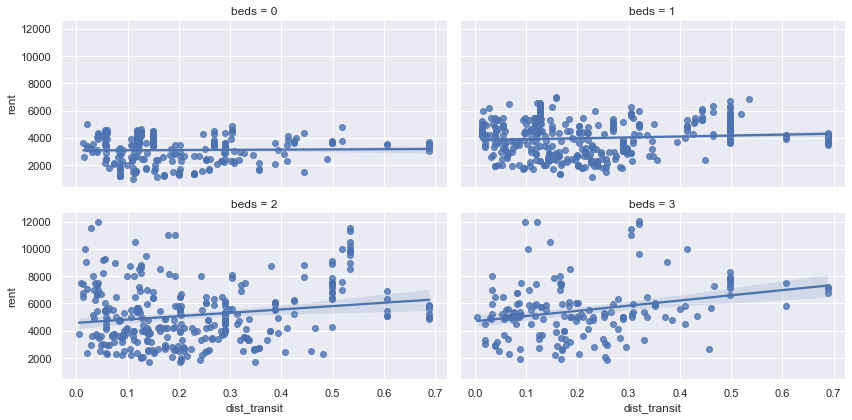

In [81]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_transit','rent')

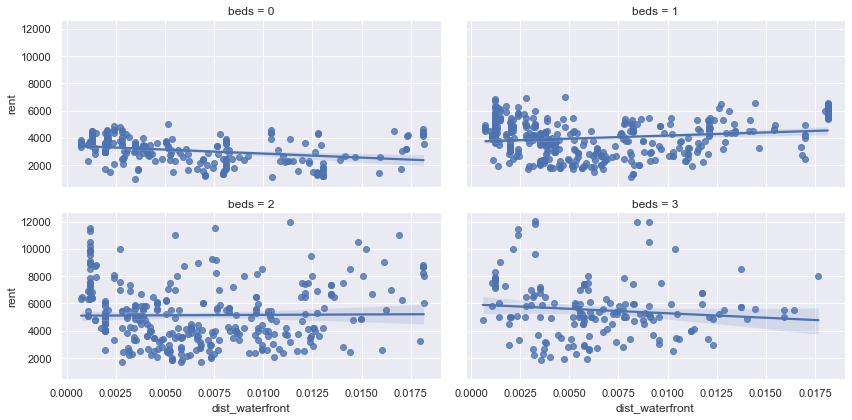

In [82]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_waterfront','rent')

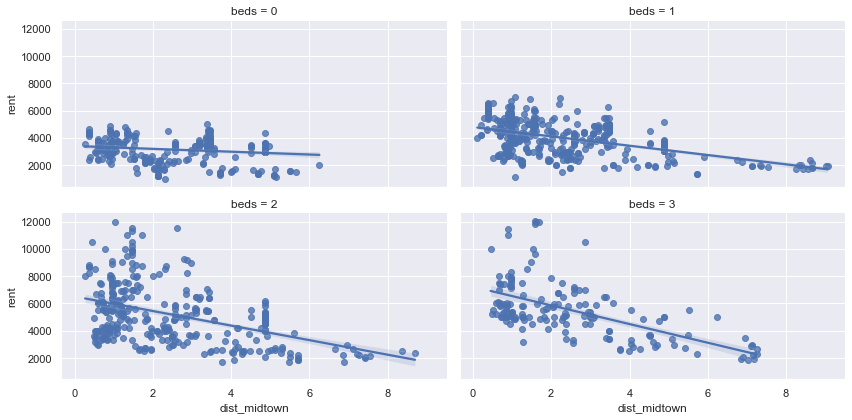

In [83]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_midtown','rent')

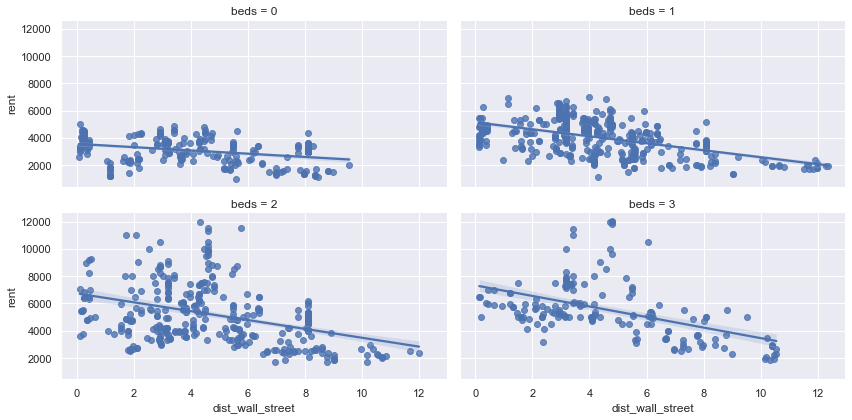

In [84]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'dist_wall_street','rent')

* Transit appears to have no noticeable affect on the price. Given that the stops are all concentrated along the middle of Manhattan, this makes sense as the further you move away from the stop, the closer you get to the waterfront. Interestingly enough, the distance to waterfront also appears to have very little correlation with the price. 
* Both distance to midtown and wall street seem to exhibit similar trends. Since they're both redundant, we'll start with the distance to wall street as the main feature.

In [85]:
# Drop the two columns
units.drop(columns={'dist_midtown'}, inplace=True)

### Visualize binary features

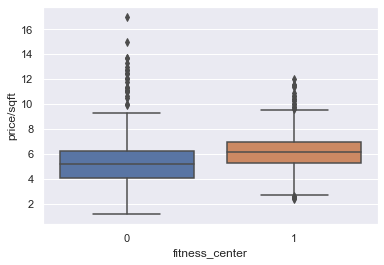

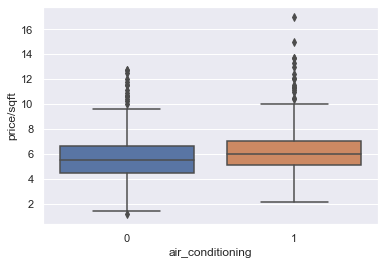

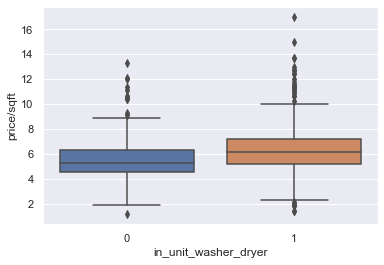

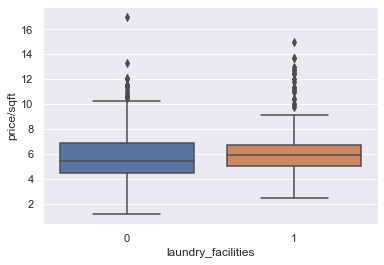

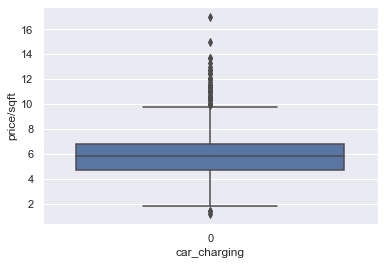

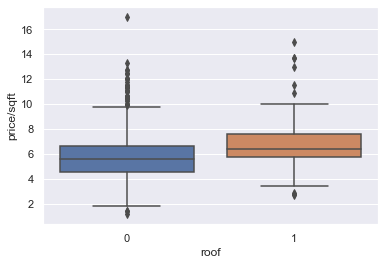

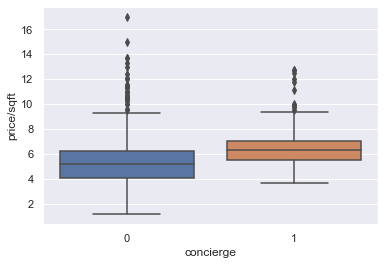

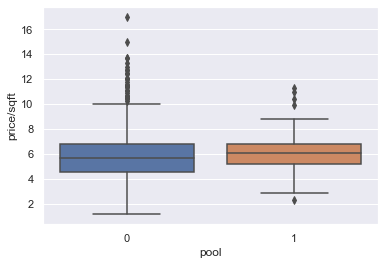

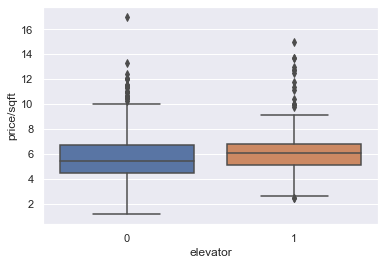

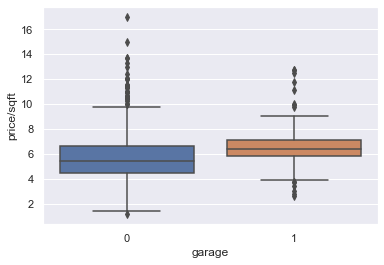

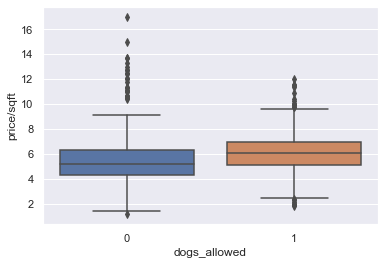

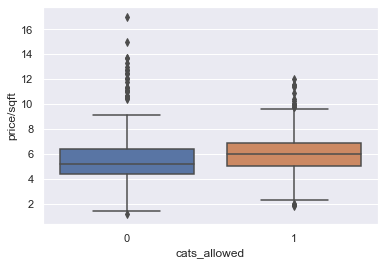

In [86]:
#plotting binary features
for i in units.columns[9:21]:
  plt.figure()
  sns.boxplot(x = i, y = 'price/sqft', data = units)
  plt.show()
  plt.close()

In [87]:
# Create new pets category
units['pets_allowed']=np.where((units.dogs_allowed == 1) | (units.cats_allowed == 1),
                               1,
                               0)

# Drop columns that are not necessary for further exploration
units.drop(columns={'dogs_allowed', 'cats_allowed', 'property_name', 'property_zipcode', 'unit_id', 'date_available', 'date_scraped', 'car_charging', 'neighborhood', 'zipcode', 'description', 'unique_features', 'city_name','year_built', 'property_url'}, inplace=True)

# Create new features from existing features

In [88]:
# Create two different columns that blend beds and baths together
units['beds_plus_baths'] = units.beds+units.baths
units['beds_times_baths'] = units.beds*units.baths

### Cluster the units based on the latitude/longitude

In [89]:
# Import K-means
from sklearn.cluster import KMeans

In [90]:
cluster_df = units.groupby(['latitude', 'longitude'], as_index=False)['price/sqft'].mean()
cluster_df.head()

,latitude,longitude,price/sqft
0,40.70461,-74.00890,6.285610
1,40.70464,-74.00755,6.539953
2,40.70520,-74.01613,5.118548
3,40.70564,-74.00878,6.682264
4,40.70578,-74.00724,5.913889


In [91]:
# Compute the elbow curve to determine the optimal number of clusters

def optimal_cluster():
    # Find the optimal number of clusters to use
    K_clusters = range(5,50)
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    sse =[]

    for k in K_clusters:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(lat_long, sample_weight=weights)
        sse.append(kmeans.inertia_)


    plt.plot(K_clusters, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Curve')
    plt.show()

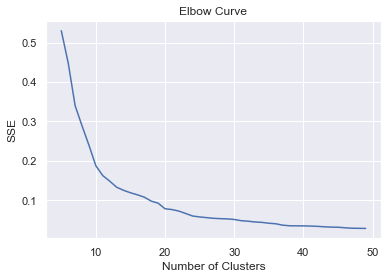

In [92]:
optimal_cluster()

Around 20ish clusters there appears to be an elbow forming. We'll explore using 22 clusters and visualize the clusters on a map.

In [93]:
def clusters(clusters:int):
    # Find the optimal number of clusters to use
    lat_long = cluster_df.iloc[:,0:2]
    weights = cluster_df.iloc[:,2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    
    kmeans = KMeans(n_clusters=clusters, **kmeans_kwargs)
    kmeans.fit(lat_long, sample_weight=weights)
    return kmeans

In [94]:
# Assign clusters to units
kmeans = clusters(20)
units['cluster_id'] = kmeans.predict(units[['latitude','longitude']])

In [95]:
fig = px.scatter_mapbox(units, lat="latitude", lon="longitude", color="cluster_id", mapbox_style="carto-positron", zoom=11.3)

fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [96]:
# Target encode the cluster id with the price/sqft mean of the cluster
# This will need to be re-done after the test-train split to avoid data leakage
# For now its computed on the whole set to visualize the correlation
units['cluster_id_encoded']=units.cluster_id.map(units.groupby('cluster_id')['price/sqft'].mean())

# Produce a correlation map

<AxesSubplot:>

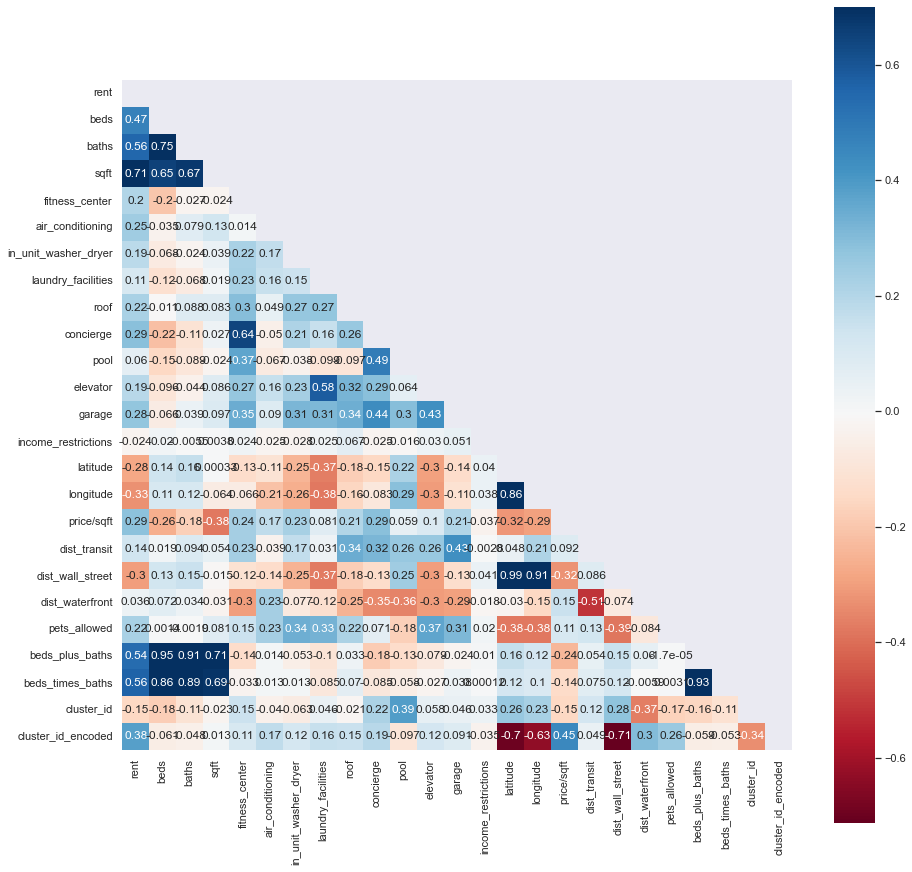

In [97]:
corr_map = units.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_map, dtype=bool))

f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr_map, square = True, vmax = 0.7, cmap = 'RdBu', annot = True, mask = mask)

In [98]:
# Drop remaining columns
units.drop(columns={'beds', 'baths', 'beds_plus_baths','income_restrictions', 'price/sqft', 'cluster_id', 'cluster_id_encoded'}, inplace=True)

In [99]:
units.head()

,rent,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,latitude,longitude,dishwasher,dist_transit,dist_wall_street,dist_waterfront,pets_allowed,beds_times_baths
9,2290.0,500.0,0,0,0,1,0,0,0,0,0,40.74761,-73.97421,0,0.228494,3.336871,0.004532,1,1.0
32,2759.0,725.0,0,0,0,0,0,0,0,1,0,40.82500,-73.94862,0,0.124283,8.718798,0.006425,1,3.0
37,4995.0,1000.0,0,0,0,1,0,0,0,0,0,40.75898,-73.96183,0,0.305744,4.352061,0.002771,1,3.0
42,5550.0,983.0,1,1,0,1,0,0,0,1,1,40.79445,-73.96973,1,0.121224,6.354176,0.007658,1,4.0
45,5700.0,983.0,1,1,0,1,0,0,0,1,1,40.79445,-73.96973,1,0.121224,6.354176,0.007658,1,4.0


# Save the data for modeling

In [100]:
units.to_csv('./data/processed/manhattan_04-20-2022.csv', index=False)